以前都是学着别人的baseline用，这次终于轮到我可以为大家贡献一下了哈哈哈

In [16]:
# 首先导入包
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
from tqdm import tqdm
import seaborn as sns


In [17]:
# 看看label文件长啥样
labels_dataframe = pd.read_csv('../data/classify-leaves/train.csv')
labels_dataframe.head(5)

,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


In [18]:
labels_dataframe.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/0.jpg,maclura_pomifera
freq,1,353


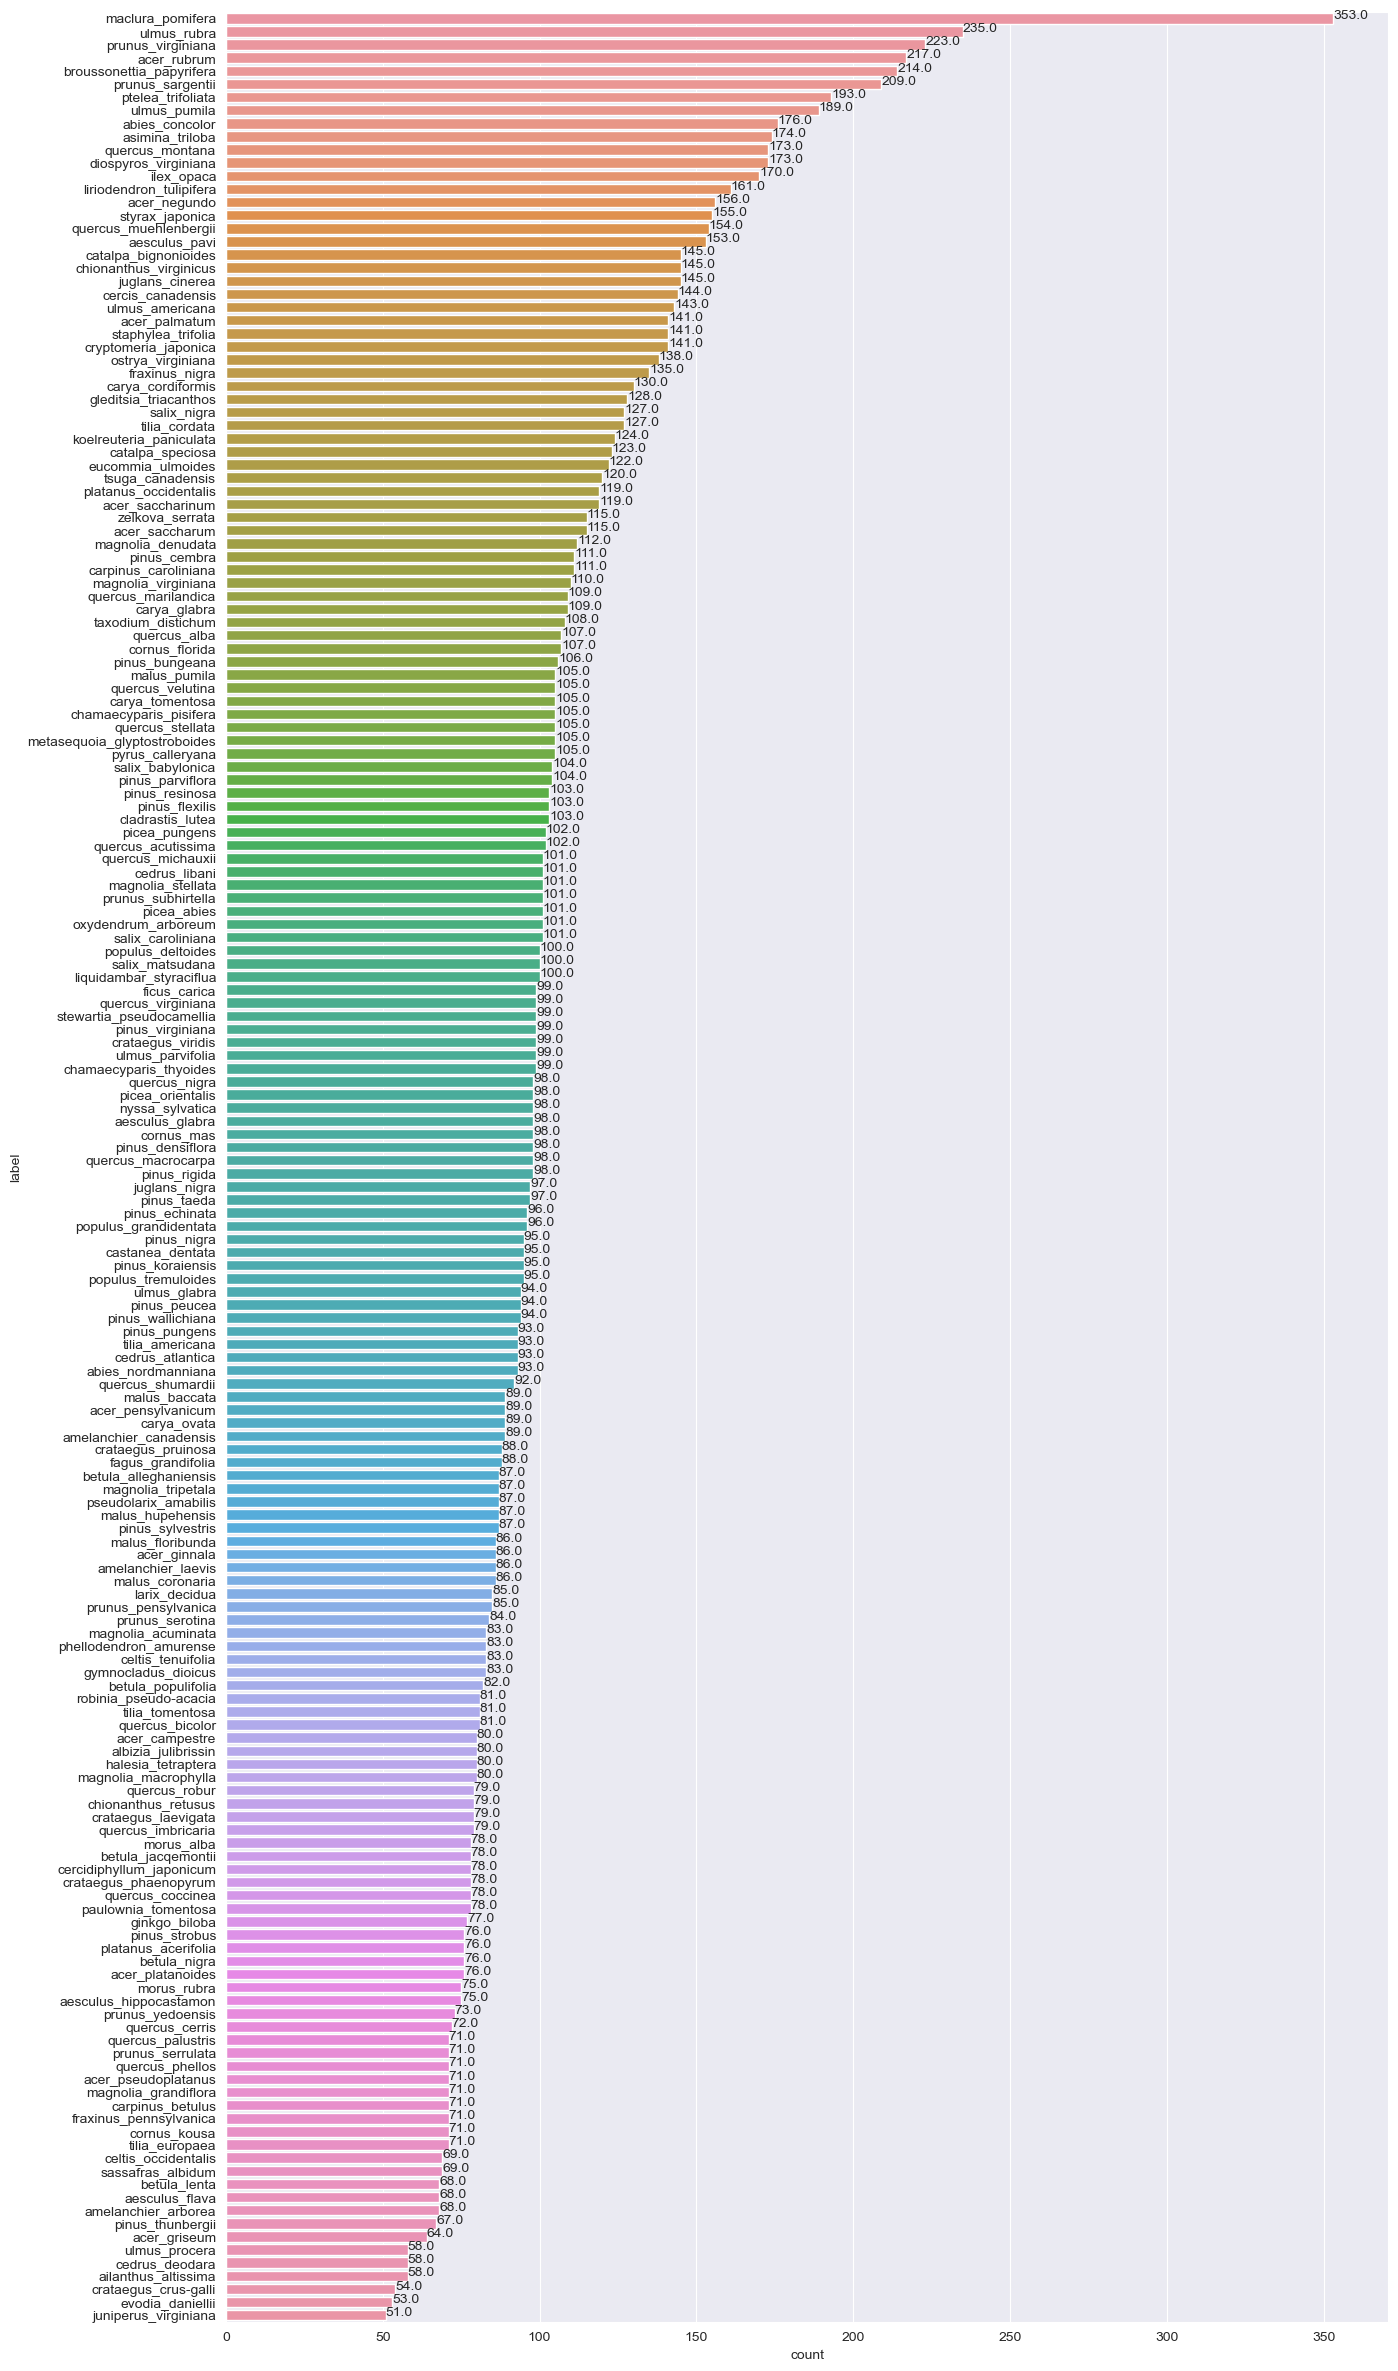

In [19]:
#function to show bar length

def barw(ax):
    for p in ax.patches:
        val = p.get_width()  #height of the bar
        x = p.get_x() + p.get_width()  # x- position 
        y = p.get_y() + p.get_height() / 2  #y-position
        ax.annotate(round(val, 2), (x, y))


#finding top leaves

plt.figure(figsize=(15, 30))
ax0 = sns.countplot(y=labels_dataframe['label'], order=labels_dataframe['label'].value_counts().index)
barw(ax0)
plt.show()

In [20]:
# 把label文件排个序
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_classes = len(leaves_labels)
print(n_classes)
leaves_labels[:10]

176


['abies_concolor',
 'abies_nordmanniana',
 'acer_campestre',
 'acer_ginnala',
 'acer_griseum',
 'acer_negundo',
 'acer_palmatum',
 'acer_pensylvanicum',
 'acer_platanoides',
 'acer_pseudoplatanus']

In [21]:
# 把label转成对应的数字
class_to_num = dict(zip(leaves_labels, range(n_classes)))
class_to_num

{'abies_concolor': 0,
 'abies_nordmanniana': 1,
 'acer_campestre': 2,
 'acer_ginnala': 3,
 'acer_griseum': 4,
 'acer_negundo': 5,
 'acer_palmatum': 6,
 'acer_pensylvanicum': 7,
 'acer_platanoides': 8,
 'acer_pseudoplatanus': 9,
 'acer_rubrum': 10,
 'acer_saccharinum': 11,
 'acer_saccharum': 12,
 'aesculus_flava': 13,
 'aesculus_glabra': 14,
 'aesculus_hippocastamon': 15,
 'aesculus_pavi': 16,
 'ailanthus_altissima': 17,
 'albizia_julibrissin': 18,
 'amelanchier_arborea': 19,
 'amelanchier_canadensis': 20,
 'amelanchier_laevis': 21,
 'asimina_triloba': 22,
 'betula_alleghaniensis': 23,
 'betula_jacqemontii': 24,
 'betula_lenta': 25,
 'betula_nigra': 26,
 'betula_populifolia': 27,
 'broussonettia_papyrifera': 28,
 'carpinus_betulus': 29,
 'carpinus_caroliniana': 30,
 'carya_cordiformis': 31,
 'carya_glabra': 32,
 'carya_ovata': 33,
 'carya_tomentosa': 34,
 'castanea_dentata': 35,
 'catalpa_bignonioides': 36,
 'catalpa_speciosa': 37,
 'cedrus_atlantica': 38,
 'cedrus_deodara': 39,
 'cedru

In [22]:
# 再转换回来，方便最后预测的时候使用
num_to_class = {v: k for k, v in class_to_num.items()}

In [23]:
# 继承pytorch的dataset，创建自己的
class LeavesData(Dataset):
    def __init__(self, csv_path, file_path, mode='train', valid_ratio=0.2, resize_height=256, resize_width=256):
        """
        Args:
            csv_path (string): csv 文件路径
            img_path (string): 图像文件所在路径
            mode (string): 训练模式还是测试模式
            valid_ratio (float): 验证集比例
        """

        # 需要调整后的照片尺寸，我这里每张图片的大小尺寸不一致#
        self.resize_height = resize_height
        self.resize_width = resize_width

        self.file_path = file_path
        self.mode = mode

        # 读取 csv 文件
        # 利用pandas读取csv文件
        self.data_info = pd.read_csv(csv_path, header=None)  #header=None是去掉表头部分
        # 计算 length
        self.data_len = len(self.data_info.index) - 1
        self.train_len = int(self.data_len * (1 - valid_ratio))

        if mode == 'train':
            # 第一列包含图像文件的名称
            self.train_image = np.asarray(
                self.data_info.iloc[1:self.train_len, 0])  #self.data_info.iloc[1:,0]表示读取第一列，从第二行开始到train_len
            # 第二列是图像的 label
            self.train_label = np.asarray(self.data_info.iloc[1:self.train_len, 1])
            self.image_arr = self.train_image
            self.label_arr = self.train_label
        elif mode == 'valid':
            self.valid_image = np.asarray(self.data_info.iloc[self.train_len:, 0])
            self.valid_label = np.asarray(self.data_info.iloc[self.train_len:, 1])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
        elif mode == 'test':
            self.test_image = np.asarray(self.data_info.iloc[1:, 0])
            self.image_arr = self.test_image

        self.real_len = len(self.image_arr)

        print('Finished reading the {} set of Leaves Dataset ({} samples found)'
              .format(mode, self.real_len))

    def __getitem__(self, index):
        # 从 image_arr中得到索引对应的文件名
        single_image_name = self.image_arr[index]

        # 读取图像文件
        img_as_img = Image.open(self.file_path + single_image_name)

        #如果需要将RGB三通道的图片转换成灰度图片可参考下面两行
        #         if img_as_img.mode != 'L':
        #             img_as_img = img_as_img.convert('L')

        #设置好需要转换的变量，还可以包括一系列的nomarlize等等操作
        if self.mode == 'train':
            transform = torchvision.transforms.Compose([
                # 随机裁剪图像，所得图像为原始面积的0.08～1之间，高宽比在3/4和4/3之间。
                # 然后，缩放图像以创建224x224的新图像
                torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                                         ratio=(3.0 / 4.0, 4.0 / 3.0)),
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.RandomRotation(degrees=(-180, 180)), # not try yet
                # 随机更改亮度，对比度和饱和度
                torchvision.transforms.ColorJitter(brightness=0.4,
                                                   contrast=0.4,
                                                   saturation=0.4),
                # 添加随机噪声
                torchvision.transforms.ToTensor(),
                # 标准化图像的每个通道
                torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                                 [0.229, 0.224, 0.225])])
        else:
            # valid和test不做数据增强
            transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(256),
                # 从图像中心裁切224x224大小的图片
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                                 [0.229, 0.224, 0.225])])

        img_as_img = transform(img_as_img)

        if self.mode == 'test':
            return img_as_img
        else:
            # 得到图像的 string label
            label = self.label_arr[index]
            # number label
            number_label = class_to_num[label]

            return img_as_img, number_label  #返回每一个index对应的图片数据和对应的label

    def __len__(self):
        return self.real_len


In [24]:
train_path = '../data/classify-leaves/train.csv'
test_path = '../data/classify-leaves/test.csv'
# csv文件中已经images的路径了，因此这里只到上一级目录
img_path = '../data/classify-leaves/'

train_dataset = LeavesData(train_path, img_path, mode='train')
val_dataset = LeavesData(train_path, img_path, mode='valid')
test_dataset = LeavesData(test_path, img_path, mode='test')
print(train_dataset)
print(val_dataset)
print(test_dataset)

Finished reading the train set of Leaves Dataset (14681 samples found)
Finished reading the valid set of Leaves Dataset (3672 samples found)
Finished reading the test set of Leaves Dataset (8800 samples found)


In [25]:
# 定义data loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=True,
    # num_workers=4
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=8,
    shuffle=False,
    # num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=8,
    shuffle=False,
    # num_workers=4
)

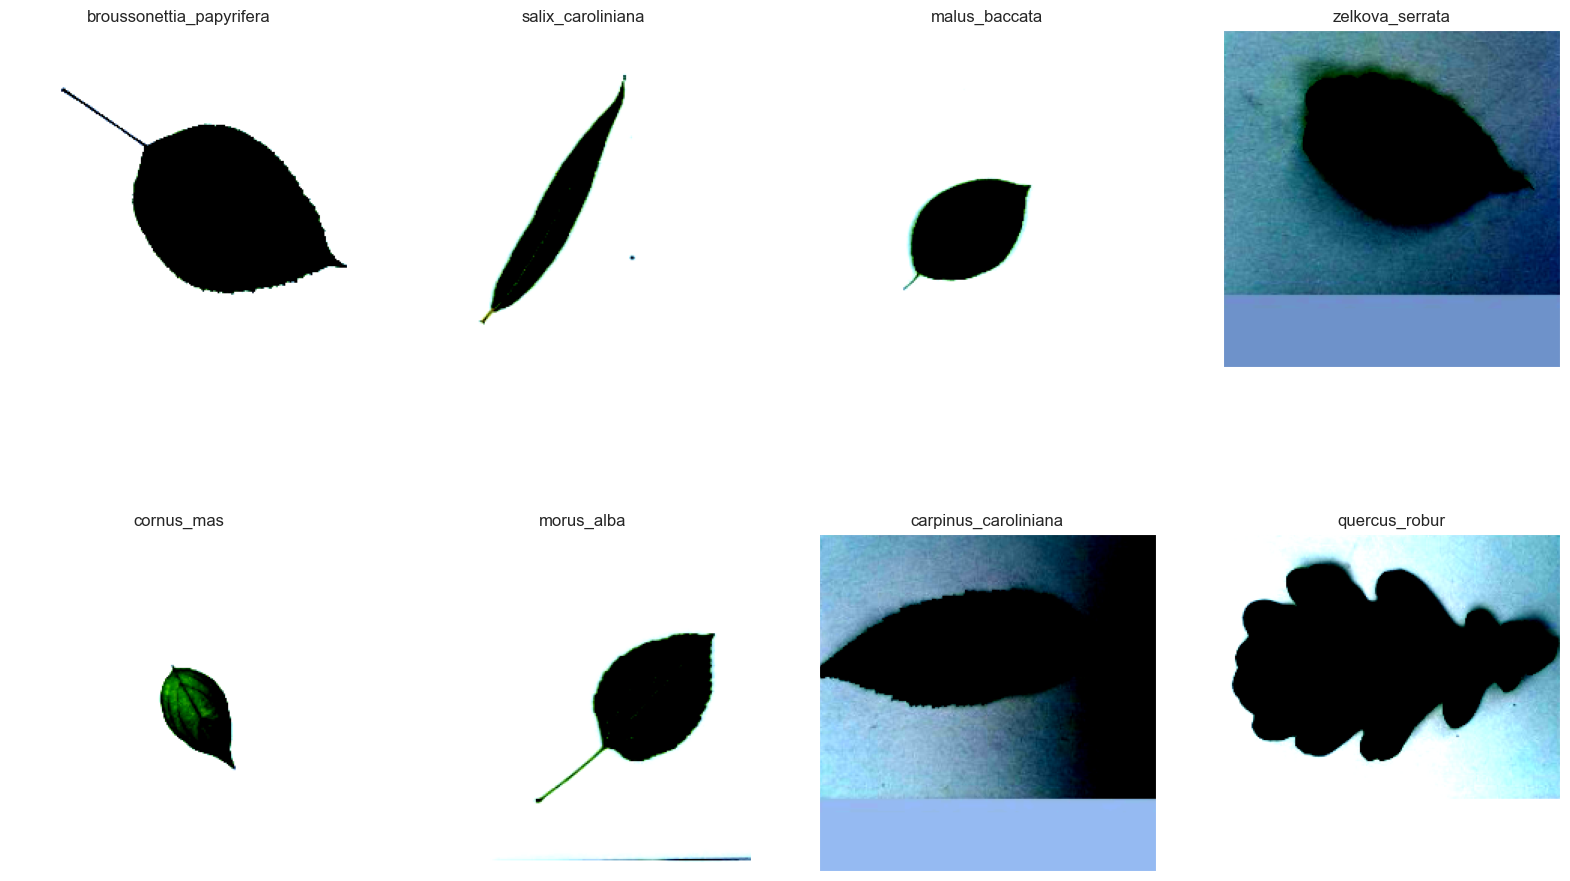

In [26]:
# 给大家展示一下数据长啥样
def im_convert(tensor):
    """ 展示数据"""

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image.clip(0, 1)

    return image


fig = plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(val_loader)
inputs, classes = next(dataiter)

for idx in range(columns * rows):
    ax = fig.add_subplot(rows, columns, idx + 1, xticks=[], yticks=[])
    ax.set_title(num_to_class[int(classes[idx])])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

In [27]:
# 看一下是在cpu还是GPU上
def get_device():
    return torch.device('mps')


device = get_device()
print(device)

mps


In [28]:
# 是否要冻住模型的前面一些层
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False


# resnet34模型
def res_model(num_classes, feature_extract=False, use_pretrained=True):
    model_ft = models.resnet34(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

In [29]:
# 超参数20, 5e-5, 5e-4
learning_rate = 5e-5
weight_decay = 5e-4
num_epoch = 30
lr_period, lr_decay = 10, 0.7

model_path = './pre_res_model.ckpt'

In [30]:

# Initialize a model, and put it on the device specified.
model = res_model(176)
model = model.to(device)
model.device = device
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_period, lr_decay)
# The number of training epochs.
n_epochs = num_epoch

best_acc = 0.0
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()
    # These are used to record information in training.
    train_loss = []
    train_accs = []
    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        # Compute the gradients for parameters.
        loss.backward()
        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
    scheduler.step()
    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):
        imgs, labels = batch
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # if the model improves, save a checkpoint at this epoch
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(best_acc))

/Users/frank/anaconda3/envs/d2l-zh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/frank/anaconda3/envs/d2l-zh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1836/1836 [02:18<00:00, 13.27it/s]


[ Train | 001/030 ] loss = 3.48133, acc = 0.25504


100%|██████████| 459/459 [00:09<00:00, 50.72it/s]


[ Valid | 001/030 ] loss = 1.87262, acc = 0.46596
saving model with acc 0.466


100%|██████████| 1836/1836 [02:19<00:00, 13.19it/s]


[ Train | 002/030 ] loss = 2.17500, acc = 0.47236


100%|██████████| 459/459 [00:09<00:00, 47.73it/s]


[ Valid | 002/030 ] loss = 1.20625, acc = 0.62119
saving model with acc 0.621


100%|██████████| 1836/1836 [02:22<00:00, 12.85it/s]


[ Train | 003/030 ] loss = 1.70793, acc = 0.57047


100%|██████████| 459/459 [00:09<00:00, 50.92it/s]


[ Valid | 003/030 ] loss = 0.96061, acc = 0.70016
saving model with acc 0.700


100%|██████████| 1836/1836 [02:18<00:00, 13.25it/s]


[ Train | 004/030 ] loss = 1.44808, acc = 0.62575


100%|██████████| 459/459 [00:09<00:00, 50.65it/s]


[ Valid | 004/030 ] loss = 0.73000, acc = 0.77342
saving model with acc 0.773


100%|██████████| 1836/1836 [02:20<00:00, 13.10it/s]


[ Train | 005/030 ] loss = 1.28814, acc = 0.66782


100%|██████████| 459/459 [00:09<00:00, 50.98it/s]


[ Valid | 005/030 ] loss = 0.78729, acc = 0.75545


100%|██████████| 1836/1836 [02:17<00:00, 13.37it/s]


[ Train | 006/030 ] loss = 1.18130, acc = 0.69247


100%|██████████| 459/459 [00:09<00:00, 47.68it/s]


[ Valid | 006/030 ] loss = 0.61268, acc = 0.80392
saving model with acc 0.804


100%|██████████| 1836/1836 [02:18<00:00, 13.22it/s]


[ Train | 007/030 ] loss = 1.09509, acc = 0.71072


100%|██████████| 459/459 [00:08<00:00, 51.15it/s]


[ Valid | 007/030 ] loss = 0.57659, acc = 0.82326
saving model with acc 0.823


100%|██████████| 1836/1836 [02:24<00:00, 12.68it/s]


[ Train | 008/030 ] loss = 1.02445, acc = 0.73203


100%|██████████| 459/459 [00:09<00:00, 48.24it/s]


[ Valid | 008/030 ] loss = 0.49607, acc = 0.85430
saving model with acc 0.854


100%|██████████| 1836/1836 [02:23<00:00, 12.82it/s]


[ Train | 009/030 ] loss = 0.98483, acc = 0.74033


100%|██████████| 459/459 [00:09<00:00, 48.80it/s]


[ Valid | 009/030 ] loss = 0.46371, acc = 0.85240


100%|██████████| 1836/1836 [02:23<00:00, 12.80it/s]


[ Train | 010/030 ] loss = 0.94066, acc = 0.74830


100%|██████████| 459/459 [00:09<00:00, 50.15it/s]


[ Valid | 010/030 ] loss = 0.42554, acc = 0.86520
saving model with acc 0.865


100%|██████████| 1836/1836 [02:24<00:00, 12.72it/s]


[ Train | 011/030 ] loss = 0.80743, acc = 0.78697


100%|██████████| 459/459 [00:09<00:00, 50.82it/s]


[ Valid | 011/030 ] loss = 0.36906, acc = 0.88725
saving model with acc 0.887


100%|██████████| 1836/1836 [02:15<00:00, 13.51it/s]


[ Train | 012/030 ] loss = 0.76937, acc = 0.79984


100%|██████████| 459/459 [00:09<00:00, 50.29it/s]


[ Valid | 012/030 ] loss = 0.33077, acc = 0.89624
saving model with acc 0.896


100%|██████████| 1836/1836 [02:16<00:00, 13.46it/s]


[ Train | 013/030 ] loss = 0.76228, acc = 0.79997


100%|██████████| 459/459 [00:09<00:00, 47.18it/s]


[ Valid | 013/030 ] loss = 0.31028, acc = 0.89760
saving model with acc 0.898


100%|██████████| 1836/1836 [02:18<00:00, 13.25it/s]


[ Train | 014/030 ] loss = 0.71982, acc = 0.81434


100%|██████████| 459/459 [00:08<00:00, 51.25it/s]


[ Valid | 014/030 ] loss = 0.28355, acc = 0.91313
saving model with acc 0.913


100%|██████████| 1836/1836 [02:18<00:00, 13.28it/s]


[ Train | 015/030 ] loss = 0.70967, acc = 0.81652


100%|██████████| 459/459 [00:09<00:00, 47.89it/s]


[ Valid | 015/030 ] loss = 0.30666, acc = 0.90577


100%|██████████| 1836/1836 [02:21<00:00, 13.01it/s]


[ Train | 016/030 ] loss = 0.69004, acc = 0.81951


100%|██████████| 459/459 [00:09<00:00, 50.36it/s]


[ Valid | 016/030 ] loss = 0.29411, acc = 0.90904


100%|██████████| 1836/1836 [02:21<00:00, 13.00it/s]


[ Train | 017/030 ] loss = 0.67807, acc = 0.82251


100%|██████████| 459/459 [00:08<00:00, 52.11it/s]


[ Valid | 017/030 ] loss = 0.26609, acc = 0.91122


100%|██████████| 1836/1836 [02:20<00:00, 13.08it/s]


[ Train | 018/030 ] loss = 0.65593, acc = 0.82945


100%|██████████| 459/459 [00:09<00:00, 48.35it/s]


[ Valid | 018/030 ] loss = 0.28428, acc = 0.91204


100%|██████████| 1836/1836 [02:25<00:00, 12.60it/s]


[ Train | 019/030 ] loss = 0.66242, acc = 0.82938


100%|██████████| 459/459 [00:09<00:00, 48.69it/s]


[ Valid | 019/030 ] loss = 0.28737, acc = 0.91939
saving model with acc 0.919


100%|██████████| 1836/1836 [02:19<00:00, 13.20it/s]


[ Train | 020/030 ] loss = 0.65994, acc = 0.82966


100%|██████████| 459/459 [00:09<00:00, 48.13it/s]


[ Valid | 020/030 ] loss = 0.32357, acc = 0.90850


100%|██████████| 1836/1836 [02:26<00:00, 12.56it/s]


[ Train | 021/030 ] loss = 0.58757, acc = 0.85029


100%|██████████| 459/459 [00:09<00:00, 47.75it/s]


[ Valid | 021/030 ] loss = 0.25266, acc = 0.92565
saving model with acc 0.926


100%|██████████| 1836/1836 [02:23<00:00, 12.78it/s]


[ Train | 022/030 ] loss = 0.57729, acc = 0.85029


100%|██████████| 459/459 [00:09<00:00, 50.72it/s]


[ Valid | 022/030 ] loss = 0.24226, acc = 0.92620
saving model with acc 0.926


100%|██████████| 1836/1836 [02:17<00:00, 13.34it/s]


[ Train | 023/030 ] loss = 0.55025, acc = 0.85730


100%|██████████| 459/459 [00:08<00:00, 52.19it/s]


[ Valid | 023/030 ] loss = 0.24514, acc = 0.93001
saving model with acc 0.930


100%|██████████| 1836/1836 [02:16<00:00, 13.44it/s]


[ Train | 024/030 ] loss = 0.53803, acc = 0.86029


100%|██████████| 459/459 [00:08<00:00, 52.18it/s]


[ Valid | 024/030 ] loss = 0.22659, acc = 0.93001


100%|██████████| 1836/1836 [02:18<00:00, 13.28it/s]


[ Train | 025/030 ] loss = 0.52780, acc = 0.86036


100%|██████████| 459/459 [00:09<00:00, 50.41it/s]


[ Valid | 025/030 ] loss = 0.22049, acc = 0.93437
saving model with acc 0.934


100%|██████████| 1836/1836 [02:21<00:00, 12.95it/s]


[ Train | 026/030 ] loss = 0.53065, acc = 0.86220


100%|██████████| 459/459 [00:08<00:00, 52.31it/s]


[ Valid | 026/030 ] loss = 0.23034, acc = 0.93437


100%|██████████| 1836/1836 [02:18<00:00, 13.27it/s]


[ Train | 027/030 ] loss = 0.53625, acc = 0.86295


100%|██████████| 459/459 [00:09<00:00, 48.83it/s]


[ Valid | 027/030 ] loss = 0.24897, acc = 0.92702


100%|██████████| 1836/1836 [02:19<00:00, 13.19it/s]


[ Train | 028/030 ] loss = 0.52801, acc = 0.86275


100%|██████████| 459/459 [00:09<00:00, 50.41it/s]


[ Valid | 028/030 ] loss = 0.24866, acc = 0.92919


100%|██████████| 1836/1836 [02:21<00:00, 13.00it/s]


[ Train | 029/030 ] loss = 0.51698, acc = 0.86601


100%|██████████| 459/459 [00:09<00:00, 48.82it/s]


[ Valid | 029/030 ] loss = 0.24442, acc = 0.92565


100%|██████████| 1836/1836 [02:21<00:00, 12.98it/s]


[ Train | 030/030 ] loss = 0.49828, acc = 0.87194


100%|██████████| 459/459 [00:09<00:00, 50.85it/s]


[ Valid | 030/030 ] loss = 0.20792, acc = 0.93845
saving model with acc 0.938


In [31]:
saveFileName = './submission.csv'

In [32]:
## predict
model = res_model(176)

# create model and load weights from checkpoint
model = model.to(device)
model.load_state_dict(torch.load(model_path))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []
# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    imgs = batch
    with torch.no_grad():
        logits = model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

preds = []
for i in predictions:
    preds.append(num_to_class[i])

test_data = pd.read_csv(test_path)
test_data['label'] = pd.Series(preds)
submission = pd.concat([test_data['image'], test_data['label']], axis=1)
submission.to_csv(saveFileName, index=False)
print("Done!!!!!!!!!!!!!!!!!!!!!!!!!!!")

100%|██████████| 1100/1100 [00:20<00:00, 52.83it/s]


Done!!!!!!!!!!!!!!!!!!!!!!!!!!!


要是大家觉得有用的话 多多给vote哈哈哈